In [1]:
%load_ext autoreload
%autoreload 2

import data
import evaluation
import feature_importance
import utils
import pandas as pd
import csv
import joblib
import math
import copy as cp
import pyxdf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import mne
import pandas as pd
import os
import copy
import matplotlib
import shap
import xgboost
import seaborn as sn
import braindecode
import scipy
import random

from tqdm import tqdm
from mne_icalabel import label_components
from mne_icalabel.gui import label_ica_components
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from ipywidgets import IntProgress
from mne import Epochs, pick_types, events_from_annotations
from mne.preprocessing.ica import corrmap  
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
# ------ fixed parameter ------

seed = 42
np.random.seed(seed) 
random.seed(a=seed, version=2)
mne.set_log_level("ERROR")

# for dataset A epoching, constant
offset = 3
sample_len = 6

file_format = "png"

# -----------------------------
# Paths 

# Sets where the folders and files for the results will be created
base_result_path = ""

# change to your locations
gme_data_path = r"C:\Users\hendr\Documents\GitProjects\Data\GME_Data"
ba_data_path = r"C:\Users\hendr\Documents\GitProjects\Data\BA_Data\iea_experiment"

# >>> pre-computed raw-files, importances, models are here: 
# https://seafile.zfn.uni-bremen.de/d/6511bfa72a644ebf8fdb/

# -----------------------------

if len(base_result_path) > 0:  
    if not os.path.exists(base_result_path): 
        os.makedirs(base_result_path)

path_shared_plots = os.path.join(base_result_path, "results/plots")
if not os.path.exists(path_shared_plots): 
    os.makedirs(path_shared_plots)

#### File structure for the data folders

##### BA Data Folder 

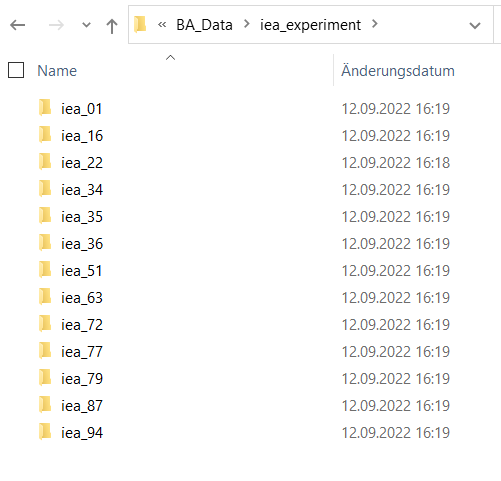

##### GME Data Folder 

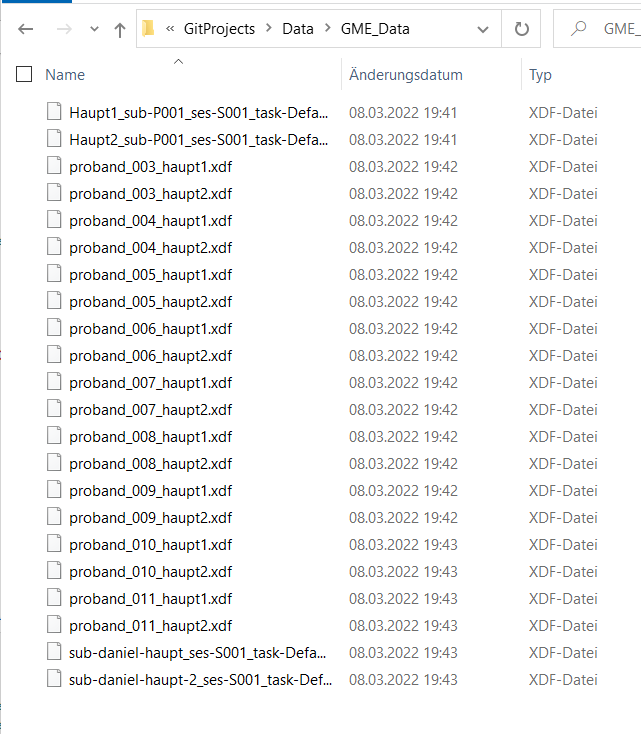


In [3]:
# ------ parameter list ------
#
# List with dicts of paramters.
# Each parameter dict indentifies which data should be used, which preprocessing steps should be done and so on.
# This allows iterating over different configurations in each cell for computing the feature importances, training the models etc. 
#
# Parameters:
# 
# load:          if True load the already computed results (such as importances or models) instead of computing them again
# data_type:     iea or gme, determines which dataset is used
# indepenent:    whether or not to use leave-one-person-out cross validation (LOPO-CV)
# window_length: the length of the window
# step_size:     if < 1, then there is overlap between the windows
# ref_type:      sets which referencing type is applied to the data. noRef := no referencing, avgRefBefore: average rereferencing for all channels before channel selection
# agg:           how to compute the channel importance based on the feature importance. max := taking the max importance of a feature, avg := taking the average
# n_splits:      if no LOPO-CV, this parameter sets the number of folds for the regular CV. 
# use_ica:       whether or not to apply automatic ICA artifact removal. 

test = False
if test: 

    params = [
        {'load': False, 'data_type': 'iea', 'independent': False,  'window_length': 4, 'step_size': 1, 'ref_type': "noRef", 'agg':'max', 'n_splits':3, 'use_ica':False},
        # {'load': False, 'data_type': 'gme', 'independent':False,  'window_length': 6, 'step_size': 1, 'ref_type': "avgRefBefore", 'agg':'max', 'n_splits':3, 'use_ica':False},
    ]

else:
    params = [
        
        {'load': True, 'data_type': 'gme', 'independent': True,  'window_length': 1.5, 'step_size': 1, 'ref_type': "avgRefBefore", 'agg':'max', 'n_splits':10, 'use_ica':False},
        {'load': True, 'data_type': 'gme', 'independent': True,  'window_length': 1.5, 'step_size': 1, 'ref_type': "avgRefBefore", 'agg':'max', 'n_splits':10, 'use_ica':True},
        {'load': True, 'data_type': 'iea', 'independent': True,  'window_length': 4, 'step_size': 1, 'ref_type': "noRef", 'agg':'max', 'n_splits':10, 'use_ica':False},
    ]

# adds more parameters to the param-dicts, such as parameter-specfic paths for saving the importances, models, results, etc. 
utils.prepare_params(params, test, base_result_path)


----------------------------
### Load and preprocess data

#### Preprocessing GME Data
Create raw objects and ICA components for the GME dataset. 
This only has to be done once by setting the create_-paramters to True

In [4]:

create_raws_unprocessed = False
create_raws_filtered = False
create_icas = False
create_raws_ica = False

# -----------------

test_str = "_test" if test else ""

# >> the Raw files are stored in the results folder and not in the data folder

raws_unprocessed_path = os.path.join(base_result_path, r"results\gme_data\raws_unprocessed" + test_str)
raws_filtered_path = os.path.join(base_result_path, r"results\gme_data\raws_filtered" + test_str)
raws_filtered_ica_path = os.path.join(base_result_path, r"results\gme_data\raws_filtered_ica" + test_str)
icas_path = os.path.join(base_result_path, r"results\gme_data\icas" + test_str)



if create_raws_unprocessed: 
    raw_list = data.load_raw_data(gme_data_path, True)
    
    if test:
        joblib.dump(raw_list[:2], filename=raws_unprocessed_path)
    else:
        joblib.dump(raw_list, filename=raws_unprocessed_path)
        
if create_raws_filtered:
    raw_list = joblib.load(raws_unprocessed_path)
    sample_len = 6
    offset = 3
    filtered = []
    
    for i, (raw, idx) in enumerate(raw_list):
        
        picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
        raw.filter(1, 60)
        raw.notch_filter(np.arange(50, 201, 50), picks=picks, fir_design='firwin')
        filtered.append((raw, idx))
        
    joblib.dump(filtered, filename=raws_filtered_path)

if create_icas:
    print("create icas")
    save_path = os.path.join(os.path.join(base_result_path, f"results/gme_data/plots"))
    filtered = joblib.load(raws_filtered_path)
    filtered_ica = []
    
    icas = []
    
    for i, (raw, idx) in enumerate(filtered):

        ica = mne.preprocessing.ICA(
            # n_components=15,
            max_iter="auto",
            method="infomax",
            random_state=0,
            fit_params=dict(extended=True),
        )
        
        ica.fit(raw)
        icas.append(ica)
        
        fig = plt.figure(figsize=(8,8))
        # ica.plot_components(inst=raw, picks=range(22), show=False)
        plt.savefig(os.path.join(save_path, f"ica_comps_raw_gme_{i}_{idx}.png"))
        plt.show()
            
    print("done")
    joblib.dump(icas, filename=icas_path)
    
if create_raws_ica: 
    filtered = joblib.load(raws_filtered_path)
    icas = joblib.load(icas_path)
    filtered_ica = []

    for (raw, idx), ica in zip(filtered, icas):
        raw.load_data()

        ic_labels = label_components(raw, ica, method="iclabel")

        labels = ic_labels["labels"]
        exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]

        # print("-"*20)
        # print(labels)
        print("Excluding these ICA components:", [labels[i] for i in exclude_idx])
        
        
        # ica.apply() changes the Raw object in-place
        ica.apply(raw, exclude=exclude_idx)

        filtered_ica.append((raw, idx))
        
    joblib.dump(filtered_ica, filename=raws_filtered_ica_path)

In [5]:

# only the path for the BA data needs to be passed since the GME data was put into the Raw-Objects which are stored in the results folder
# and the path for the results is already stored in the params

data.load_and_preprocess_data_from_param(params, ba_data_path)

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


-----------------------
## 1. Selection by Random Forest Importance



#### Calculate Feature Importance

In [6]:
method = 'rf'

for p in params:
    utils.print_param(p)
    load = p['load']
    if load: continue
    data_type = p['data_type']
    save_path = p['paths']['imp'][method]
    agg_type = p['agg']
    
    X, y, folds, fns = p['data']
    best_electrodes, time = feature_importance.get_importances_rf_importance(X, y, fns, plot=False, agg_type=agg_type)
    
    joblib.dump(time, save_path + "_time")      
    joblib.dump(best_electrodes, save_path)      

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


#### Plot Importance

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False


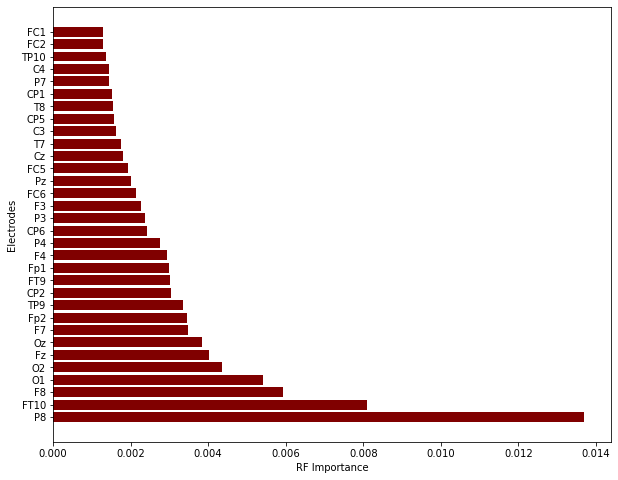

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True


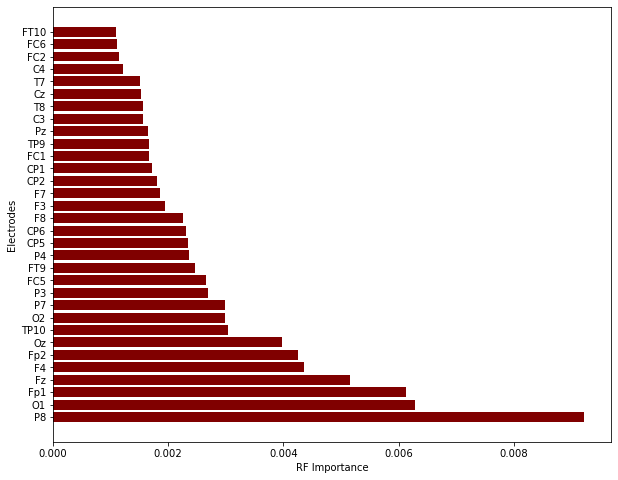

---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


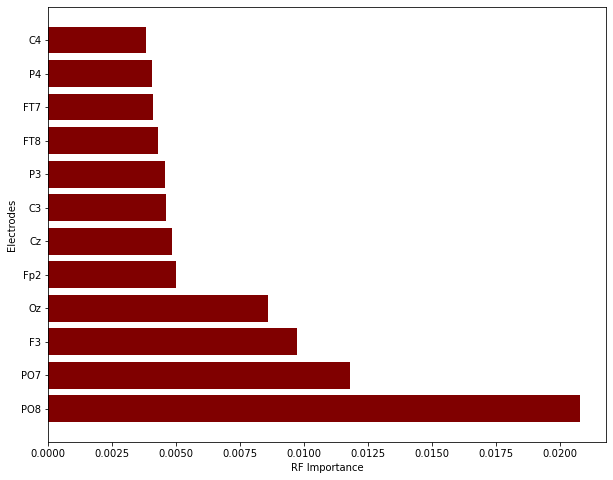

In [7]:
evaluation.plot_importance_from_param(params, "rf", "RF Importance", file_format)

#### Train models

In [8]:
evaluation.train_models_from_param(params, 'rf')

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


#### Plot classification results

In [9]:
evaluation.plot_classification_results_from_param(params, 'rf', file_format)

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


__________________
## 2. Auswahl über Mutual Information

#### Calculate Feature Importance

In [10]:
method = 'mi'

for p in params:
    utils.print_param(p)
    load = p['load']
    if load: continue
    data_type = p['data_type']
    save_path = p['paths']['imp'][method]
    agg_type = p['agg']
    
    X, y, folds, fns = p['data']
    best_electrodes, time = feature_importance.get_importances_mutual_information(X, y, fns, plot=False, agg_type=agg_type)
    
    joblib.dump(time, save_path + "_time")      
    joblib.dump(best_electrodes, save_path)   

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


#### Plot Importance

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False


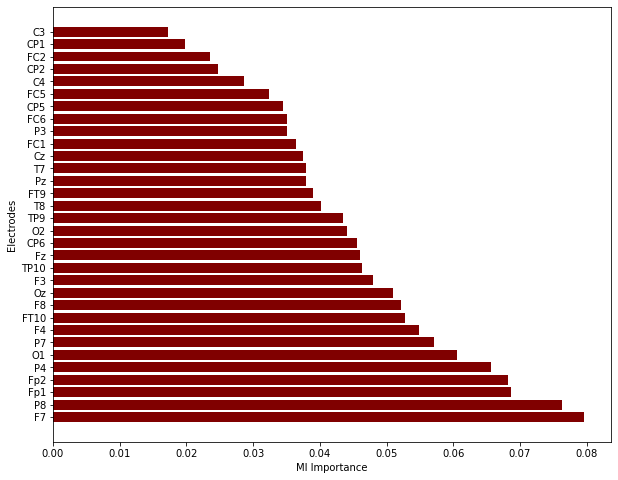

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True


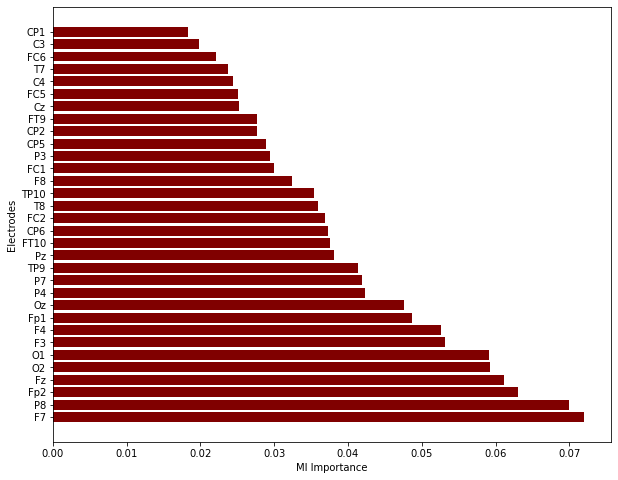

---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


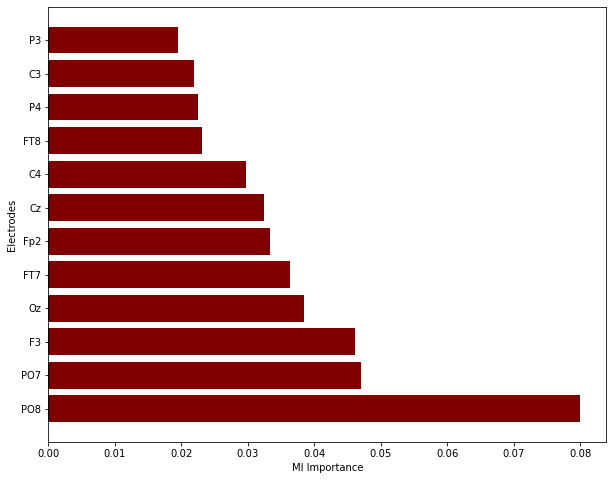

In [11]:
evaluation.plot_importance_from_param(params, "mi", "MI Importance", file_format)

#### Train models

In [12]:
evaluation.train_models_from_param(params, 'mi')

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


#### Plot classification results

In [13]:
evaluation.plot_classification_results_from_param(params, 'mi', file_format)

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


______________________________
## 3. Auswahl über Permutation Importance



#### Calculate Feature Importance

In [14]:
method = 'pi'
if test: n_repeats = 1 # 10
else: n_repeats = 10

for p in params:
    utils.print_param(p)
    load = p['load']
    if load: continue
    data_type = p['data_type']
    save_path = p['paths']['imp'][method]
    agg_type = p['agg']
    
    X, y, folds, fns = p['data']

    model_res = evaluation.train_and_run_models(X, y, folds, models=None, show_progress=False)    

    (best_electrodes, imps_per_fold), time = feature_importance.get_importances_permutation_importance(
            model_res[0].models, X, y, folds, fns, n_repeats=n_repeats, plot=False, agg_type=agg_type)
    
    joblib.dump(best_electrodes, save_path) 
    joblib.dump(imps_per_fold, save_path + "_per_fold") 
    joblib.dump(time, save_path + "_time")      
    
    print(save_path)


---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


#### Plot Importance

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False


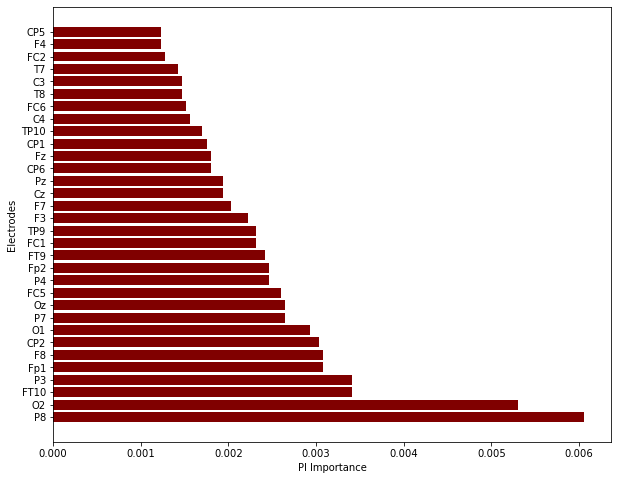

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True


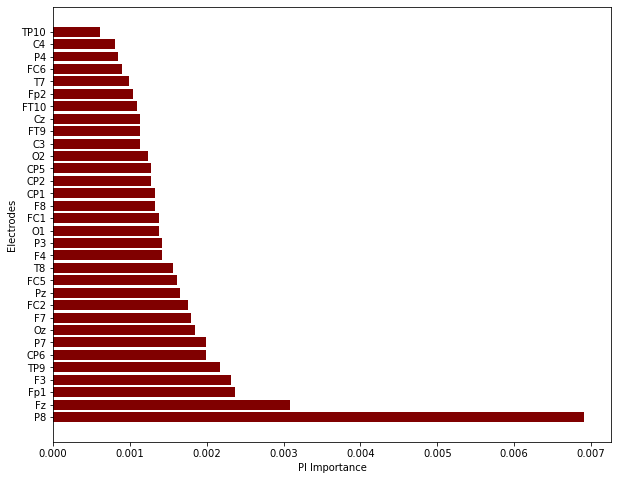

---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


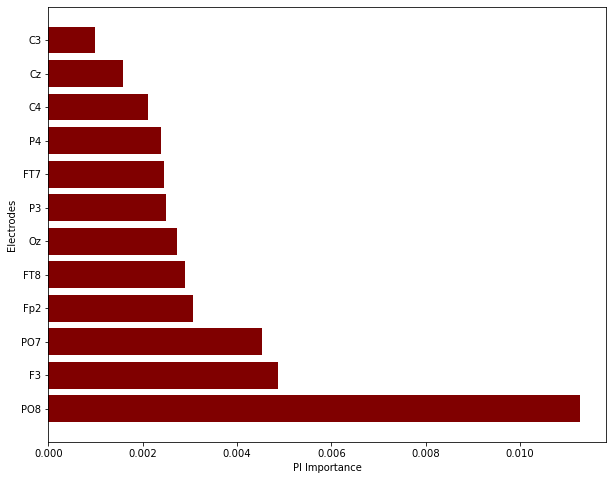

In [15]:
evaluation.plot_importance_from_param(params, "pi", "PI Importance", file_format)

#### Train models

In [16]:
evaluation.train_models_from_param(params, 'pi')

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


#### Plot classification results

In [17]:
evaluation.plot_classification_results_from_param(params, 'pi', file_format)

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


___________________________________
## 4. Auswahl über Elektroden-Ablation 

### Calculate Feature Importance

In [18]:
method = 'abl'

for p in params:
    utils.print_param(p)
    load = p['load']
    if load: continue
    data_type = p['data_type']
    save_path = p['paths']['imp'][method]
    agg_type = p['agg']
    independent = p['independent']
    ref_type = p['ref_type']
    
    X, y, folds, fns = p['data']
    ch_names = p['ch_names']
    
    whole_data_path = p['paths']['whole']
    num_chns = p['num_channels']
    
    window_len = p['window_length']
    step_size = p['step_size']
    models = [(RandomForestClassifier(random_state=0), "RandomForest")]
    (best_electrodes, imps_per_fold), time = feature_importance.get_ablation_importance(models, ch_names, None, sample_len, offset,
                                                                 window_len, step_size, independent, ref_type=ref_type, 
                                                                 whole_data_path=whole_data_path)
    print(len(best_electrodes))
    joblib.dump(best_electrodes, save_path)
    joblib.dump(imps_per_fold, save_path + "_per_fold")
    joblib.dump(time, save_path + "_time")     


---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


### Plot Feature Importance

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False


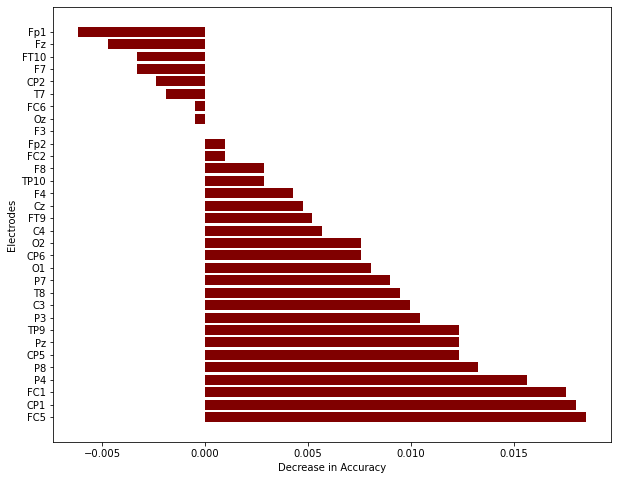

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True


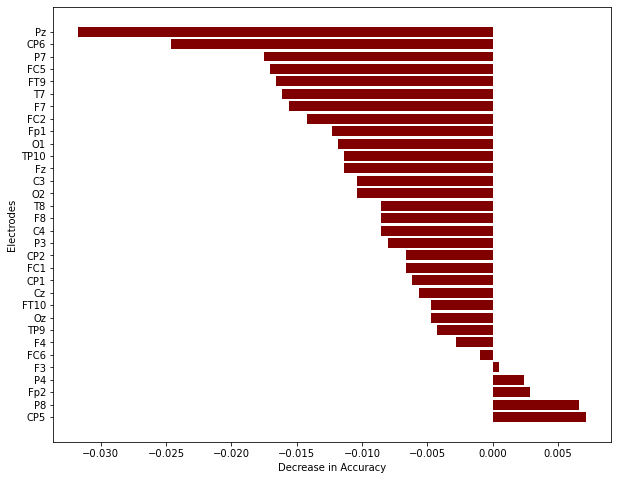

---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


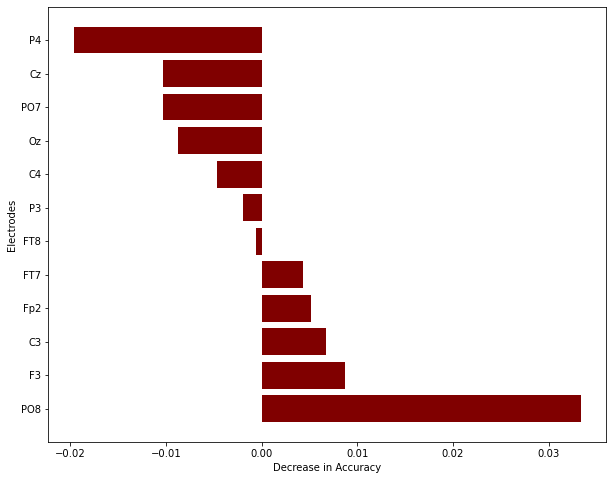

In [19]:
# print(best_electrodes)

evaluation.plot_importance_from_param(params, "abl", "Decrease in Accuracy", file_format)

### Train models

In [20]:
evaluation.train_models_from_param(params, 'abl')

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


#### Plot classification results

In [21]:
evaluation.plot_classification_results_from_param(params, 'abl', file_format)

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


_____________________________

## 6. Random Selection of Electrodes

In [22]:
evaluation.train_models_from_param(params, 'random', random=True)

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


#### Plot classification results

In [23]:
evaluation.plot_classification_results_from_param(params, 'random', file_format)

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


___________________________________
## 5. Auswahl über SHAP

### Calculate Feature Importance

In [24]:
method = 'shap'

for p in params:
    utils.print_param(p)
    if p['load']: continue
    
    data_type = p['data_type']
    save_path = p['paths']['imp'][method]
    agg_type = p['agg']
    
    X, y, folds, fns = p['data']
    
    (best_electrodes, imps_per_fold), time = feature_importance.get_importances_shap(X, y, folds, fns, plot=False, agg_type=agg_type, test=test)
    
    joblib.dump(best_electrodes, save_path)                
    joblib.dump(imps_per_fold, save_path + "_per_fold")      
    joblib.dump(time, save_path + "_time")     

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


### Plot Importance

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False


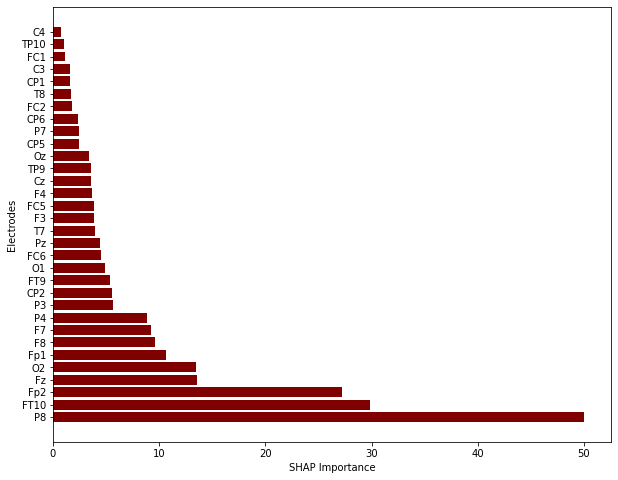

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True


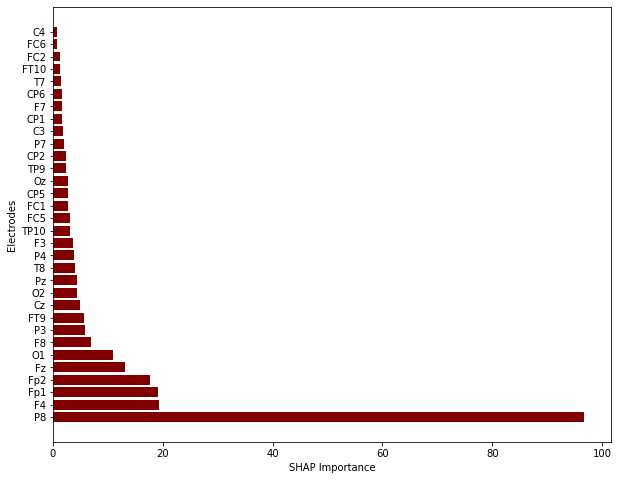

---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


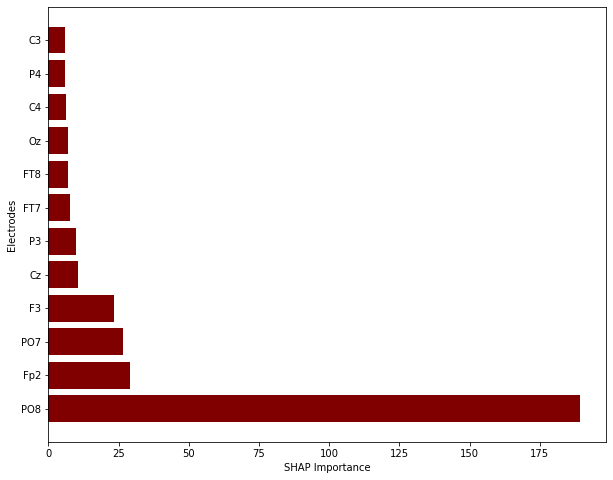

In [25]:
evaluation.plot_importance_from_param(params, "shap", "SHAP Importance", file_format)

### Train models

In [26]:
evaluation.train_models_from_param(params, 'shap') 

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


#### Plot classification results

In [27]:
evaluation.plot_classification_results_from_param(params, 'shap', file_format)

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


--------------------

## Evaluation of results

#### Execution Time of Feature Importance Algorithms

In [28]:
times_per_param = []

for p in params:
    utils.print_param(p)
    result_path = p['paths']['plots']['all']

    data_type = p['data_type']
    agg_type = p['agg']
    
    times = []
    for m in ['rf', 'mi', 'pi', 'abl', 'shap']:
        time_path = p['paths']['imp'][m] + "_time"   
        time = joblib.load(time_path)
        times.append((time, m))

    for t, m in times:
        print(m+":", str(round(t,3)) + "s")
        
    times_per_param.append(times)

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
rf: 4.976s
mi: 10.092s
pi: 1917.479s
abl: 1514.443s
shap: 15286.41s
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
rf: 5.28s
mi: 13.48s
pi: 2018.298s
abl: 1672.347s
shap: 13340.555s
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False
rf: 3.165s
mi: 5.007s
pi: 579.03s
abl: 482.529s
shap: 5595.698s


#### Line plot over methods

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


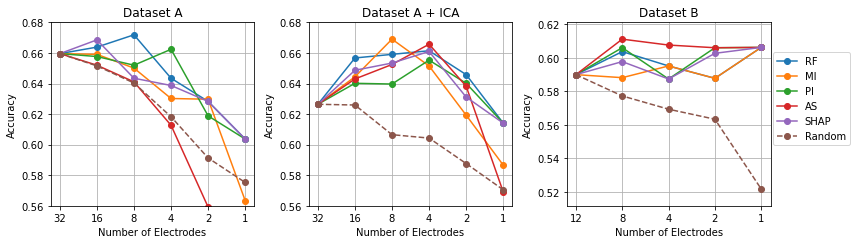

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False


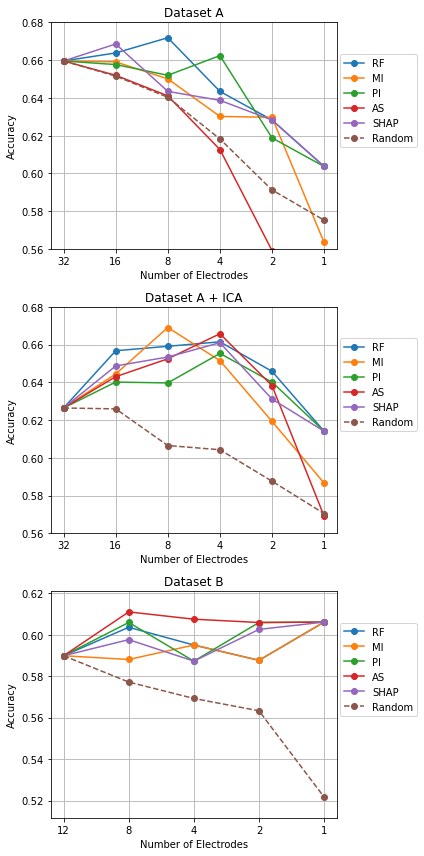

In [29]:
# horizontal = False

# takes a while since I only saved the predictions and not the accuracies

for horizontal in [True, False]:

    if horizontal: 
        # f, axarr = plt.subplots(4, 4, gridspec_kw = {'wspace':0, 'hspace':0})
        fig, ax = plt.subplots(1,3, figsize=(12, 3.5)) # ,  gridspec_kw = {'wspace':0, 'hspace':0})
    else:
        # f, axarr = plt.subplots(4, 4, gridspec_kw = {'wspace':0, 'hspace':0})
        fig, ax = plt.subplots(3,1, figsize=(6, 12)) # ,  gridspec_kw = {'wspace':0, 'hspace':0})

    idx = 0
    titles = ['Dataset A', 'Dataset A + ICA', 'Dataset B']
    for p, title in zip(params,titles):
        utils.print_param(p)
        num_channels = p['num_channels'] 

        if idx == 2:
            evaluation.line_plot_over_methods(ax[idx], data, p, num_channels, file_format, title=title, idx=idx, vmin='auto', vmax='auto', horizontal=horizontal)
        else:
            evaluation.line_plot_over_methods(ax[idx], data, p, num_channels, file_format, title=title, idx=idx, vmin=0.56, vmax=0.68, horizontal=horizontal)

        idx += 1

    plt.tight_layout()
    h_str = "_h" if horizontal else ""
    
    plt.savefig(os.path.join(path_shared_plots, f"lineplot_best{h_str}.{file_format}"), bbox_inches='tight')
    plt.show()

#### Topographic Map

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False
['Cz', 'Fp2', 'F3', 'FT7', 'C3', 'C4', 'FT8', 'P3', 'P4', 'PO7', 'PO8', 'Oz']


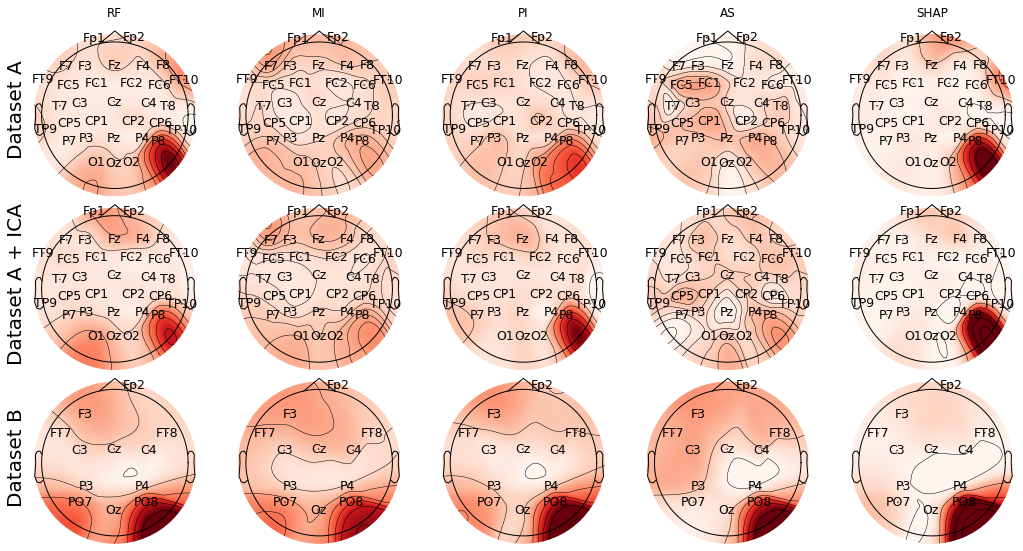

In [30]:
fig, ax = plt.subplots(3,5, figsize=(15,8))

idx = 0

titles = ['Dataset A', 'Dataset A + ICA', 'Dataset B']
for p, title in zip(params, titles):
    utils.print_param(p)
    evaluation.topo_plot_map(ax[idx], p, file_format, fontsize=18, title=title, idx=idx)
    idx += 1
    
fs = 20
ax[0][0].set_ylabel('Dataset A', rotation = 90, weight = 'normal', fontsize = fs)    
ax[1][0].set_ylabel('Dataset A + ICA', rotation = 90, weight = 'normal', fontsize = fs)    
ax[2][0].set_ylabel('Dataset B', rotation = 90, weight = 'normal', fontsize = fs)    

plt.tight_layout()
plt.subplots_adjust(hspace=0.0, wspace=0.0)

plt.savefig(os.path.join(path_shared_plots, f"topo.{file_format}"))

plt.show()

#### Plot for Importances
(also produces the entries for the latex table for the best n channels + frequency band)

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False

& P8 $\alpha$& FT10 $\delta$& F8 $\delta$& O1 $\delta$& O2 $\alpha$& Fz $\delta$& Oz $\alpha$& F7 $\delta$& Fp2 $\delta$& TP9 $\delta$& CP2 $\gamma$& FT9 $\delta$\\
& F7 $\delta$& P8 $\alpha$& Fp1 $\beta$& Fp2 $\delta$& P4 $\alpha$& O1 $\delta$& P7 $\delta$& F4 $\delta$& FT10 $\delta$& F8 $\delta$& Oz $\alpha$& F3 $\beta$\\
& P8 $\alpha$& O2 $\alpha$& FT10 $\delta$& P3 $\theta$& Fp1 $\beta$& F8 $\delta$& CP2 $\gamma$& O1 $\delta$& P7 $\delta$& Oz $\alpha$& FC5 $\beta$& P4 $\alpha$\\
& FC5 $\beta$& CP1 $\gamma$& FC1 $\theta$& P4 $\alpha$& P8 $\alpha$& CP5 $\gamma$& Pz $\theta$& TP9 $\delta$& P3 $\theta$& C3 $\beta$& T8 $\delta$& P7 $\delta$\\
& P8 $\alpha$& FT10 $\delta$& Fp2 $\delta$& Fz $\delta$& O2 $\alpha$& Fp1 $\beta$& F8 $\delta$& F7 $\delta$& P4 $\alpha$& P3 $\theta$& CP2 $\gamma$& FT9 $\delta$\\
................

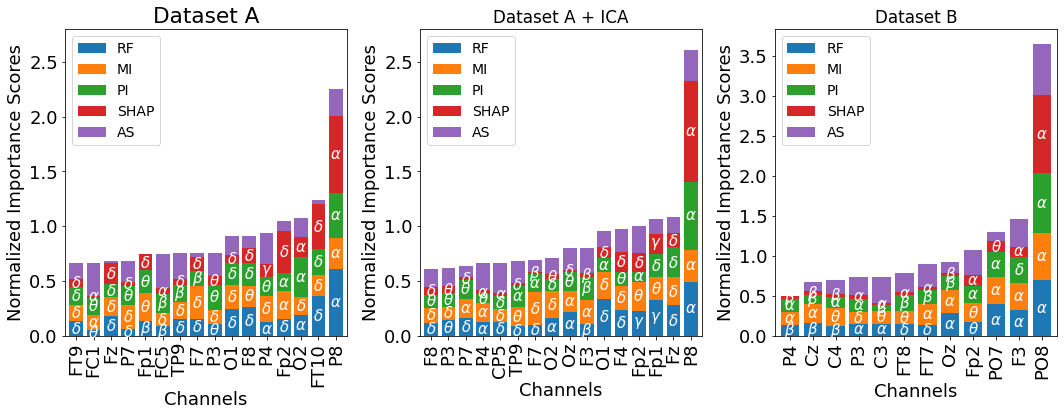

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False

& P8 $\alpha$& FT10 $\delta$& F8 $\delta$& O1 $\delta$& O2 $\alpha$& Fz $\delta$& Oz $\alpha$& F7 $\delta$& Fp2 $\delta$& TP9 $\delta$& CP2 $\gamma$& FT9 $\delta$\\
& F7 $\delta$& P8 $\alpha$& Fp1 $\beta$& Fp2 $\delta$& P4 $\alpha$& O1 $\delta$& P7 $\delta$& F4 $\delta$& FT10 $\delta$& F8 $\delta$& Oz $\alpha$& F3 $\beta$\\
& P8 $\alpha$& O2 $\alpha$& FT10 $\delta$& P3 $\theta$& Fp1 $\beta$& F8 $\delta$& CP2 $\gamma$& O1 $\delta$& P7 $\delta$& Oz $\alpha$& FC5 $\beta$& P4 $\alpha$\\
& FC5 $\beta$& CP1 $\gamma$& FC1 $\theta$& P4 $\alpha$& P8 $\alpha$& CP5 $\gamma$& Pz $\theta$& TP9 $\delta$& P3 $\theta$& C3 $\beta$& T8 $\delta$& P7 $\delta$\\
& P8 $\alpha$& FT10 $\delta$& Fp2 $\delta$& Fz $\delta$& O2 $\alpha$& Fp1 $\beta$& F8 $\delta$& F7 $\delta$& P4 $\alpha$& P3 $\theta$& CP2 $\gamma$& FT9 $\delta$\\
................

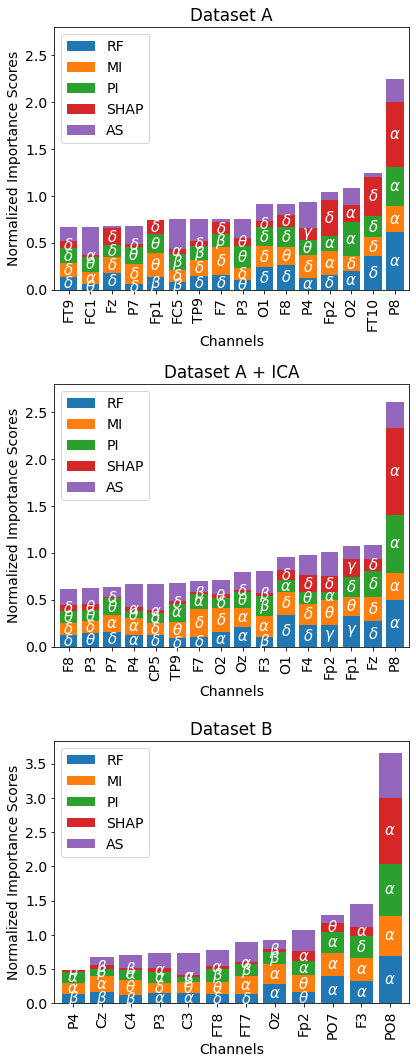

In [31]:

for horizontal in [True, False]:
    if horizontal: 
        fig, ax = plt.subplots(1,3, figsize=(15,6))
    else:
        fig, ax = plt.subplots(3,1, figsize=(6,15))
        
    cols_all = []
    
    titles = ['Dataset A', 'Dataset A + ICA', 'Dataset B']
    for idx, (p,title) in enumerate(zip(params,titles)):
    
        if idx < 2:
            ylim = 2.8
        else:
            ylim = None

        utils.print_param(p)
        print() 
        
        ax[idx].set_title(title)
        plt.rcParams['font.size'] = str(14)
        cols = evaluation.plot_importances_from_param(ax[idx], p, file_format, width=0.8, ylim=ylim, num_chn=16)
        
        cols_all.append(cols)
        idx += 1
    
    h_str = "_h" if horizontal else ""
    plt.tight_layout()
    
    plt.savefig(os.path.join(path_shared_plots, f"barchart_stacked{h_str}.{file_format}"), bbox_inches='tight')
    plt.show()    

#### Correlations

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
(5, 32)
['RF', 'MI', 'PI', 'AS', 'SHAP']
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
(5, 32)
['RF', 'MI', 'PI', 'AS', 'SHAP']
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False
(5, 12)
['RF', 'MI', 'PI', 'AS', 'SHAP']
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
------------ pi
------------ abl
------------ shap


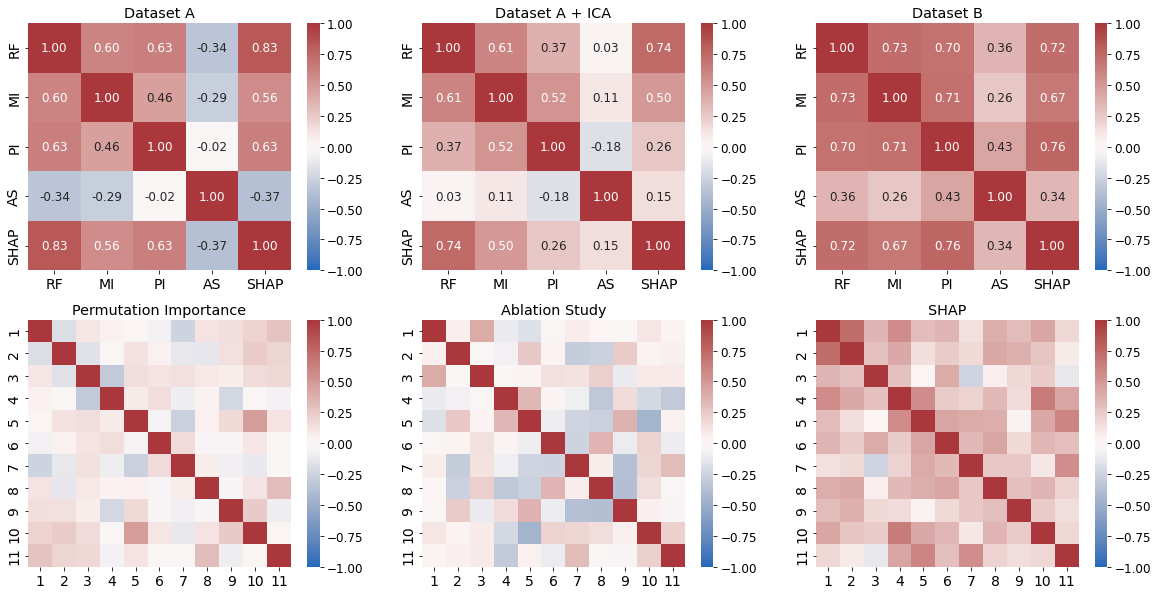

---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: False
(5, 32)
['RF', 'MI', 'PI', 'AS', 'SHAP']
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
(5, 32)
['RF', 'MI', 'PI', 'AS', 'SHAP']
---------------------------------------- 
data: iea , independent: True , win_len: 4 , step_size 1 , agg: max , n_splits: 10 , ref type: noRef , use ica: False
(5, 12)
['RF', 'MI', 'PI', 'AS', 'SHAP']
---------------------------------------- 
data: gme , independent: True , win_len: 1.5 , step_size 1 , agg: max , n_splits: 10 , ref type: avgRefBefore , use ica: True
------------ pi
------------ abl
------------ shap


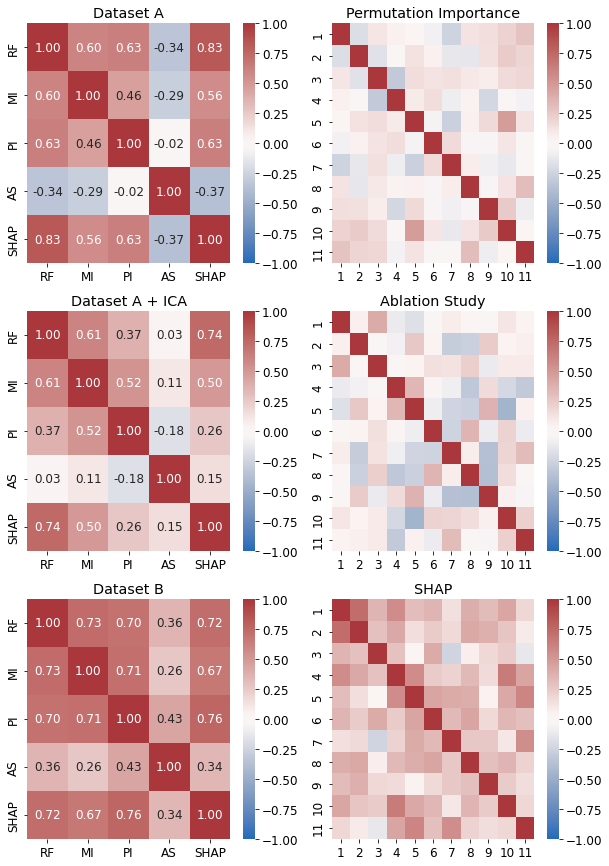

In [32]:
for horizontal in [True, False]:
    
    if horizontal: 
        fig, axes = plt.subplots(2,3, figsize=(20, 10))
    else:
        fig, axes = plt.subplots(3,2, figsize=(10, 15))


    titles = ['Dataset A', 'Dataset A + ICA', 'Dataset B']

    idx = 0
    for p,title in zip(params, titles):

        if horizontal:         
            ax = axes[0][idx]
        else:
            ax = axes[idx][0]

        utils.print_param(p)
        plt.rcParams['font.size'] = str(12)
        evaluation.correlation_rankings(ax, p, file_format, width_per_subplot=5, title=title, idx=0)
        idx += 1

    # ----------------------------------------

    w = 4.5
    if horizontal: 
        ax = axes[1]
    else:
        ax = np.array([axes[0][1], axes[1][1], axes[2][1]])

    idx = 0
    param = params[1]

    utils.print_param(param)    

    evaluation.correlation_rankings_folds(ax, param, file_format, width_per_subplot=3)
    idx += 1

    h_str = "_h" if horizontal else ""
        
    plt.savefig(os.path.join(path_shared_plots, f"corr_folds{h_str}.{file_format}"), bbox_inches='tight')
    plt.show()


#### Best n channels per method

In [33]:
n = 8

for param in params:
    result_path = param['paths']['plots']['all']
    rankings = []
    methods = ['rf','mi','pi','abl','shap']
    
    for m in methods:
        imp_path = param['paths']['imp'][m]

        electrodes = joblib.load(imp_path)
        
        chns = [(e,f) for e,f,s in electrodes]
        
        print(m, chns[:n])
    print("...............")
    

rf [('P8', 'alpha'), ('FT10', 'delta'), ('F8', 'delta'), ('O1', 'delta'), ('O2', 'alpha'), ('Fz', 'delta'), ('Oz', 'alpha'), ('F7', 'delta')]
mi [('F7', 'delta'), ('P8', 'alpha'), ('Fp1', 'theta'), ('Fp2', 'alpha'), ('P4', 'delta'), ('O1', 'delta'), ('P7', 'delta'), ('F4', 'delta')]
pi [('P8', 'alpha'), ('O2', 'alpha'), ('FT10', 'delta'), ('P3', 'theta'), ('Fp1', 'theta'), ('F8', 'delta'), ('CP2', 'alpha'), ('O1', 'delta')]
abl [('FC5', 'all'), ('CP1', 'all'), ('FC1', 'all'), ('P4', 'all'), ('P8', 'all'), ('CP5', 'all'), ('Pz', 'all'), ('TP9', 'all')]
shap [('P8', 'alpha'), ('FT10', 'delta'), ('Fp2', 'delta'), ('Fz', 'delta'), ('O2', 'alpha'), ('Fp1', 'delta'), ('F8', 'delta'), ('F7', 'delta')]
...............
rf [('P8', 'alpha'), ('O1', 'delta'), ('Fp1', 'gamma'), ('Fz', 'delta'), ('F4', 'delta'), ('Fp2', 'gamma'), ('Oz', 'alpha'), ('TP10', 'delta')]
mi [('F7', 'delta'), ('P8', 'alpha'), ('Fp2', 'theta'), ('Fz', 'delta'), ('O2', 'delta'), ('O1', 'delta'), ('F3', 'alpha'), ('F4', 'delt